# CSI 5155 Project - Group 23
# Prediction of the Likelihood to download an Apple App Store Strategy Game
### Julian Templeton, 8229400

**Description**   
This notebook will provide insight into how an app's characteristics (excluding total downloads) affect the average rating received (in a sense... diswcussed below). Specifically, we will be looking into Startegy Games on the Apple App store. It should be noted that applications are rated on a scale from 1 to 5 with 5 being the best and 1 being the worst.   

The dataset that will be used is from: https://www.kaggle.com/tristan581/17k-apple-app-store-strategy-games   

This dataset provides many details about applications and includes their average user rating. Many of the provided details are shared by all apps, and therefore this notebook will transform this data into a comprehensive set of features that provide a better representation of characteristics every application will have. This dataset only contains missing values for applications with less than five ratings. These rows will not be used as part of the training or testing to preserve only the highest quality data (majority is non-missing).   

Although inherently a regression task, this notebook groups the data into a binary classification task that is relevant to real-world studies on how application ratings affect downloads. The premise of these groupings are based on the following two articles:  
1) https://www.adweek.com/digital/how-app-store-ratings-impact-downloads-infographic/, which states that 67% of the top 100 free iPhone apps have a rating of four stars or better (implying that better ratings refer to higher downloads)    
2) https://cs-agents.com/blog/appreviews/, which is a comprehensive article stating that 96% of users consider downloading an app with at least four stars. Comparing this to the 50% who consider downloading an app with three stars and 15% considering to download an app with two stars. This article also states that ratings and reviews are the third most influencial part of an app correlating to the number of downloads (better rating is influencial to a better download).   

Thus, we convert the rating regression task into the following binary Supervised Learning classification task. We want to understand the chances for a startegy game on the app store to be downloaded or ignored. We say that a strategy game will be downloaded (class=Download, positive class) if it has an average user rating 4.0 <= rating <= 5.0 and that a strategy game may be ignored (class=Ignore, negative class) if it has an average user rating < 4.0.   

Following the details from the provided articles, this classification task is a realistic representation of the effect of ratings on total downloads in the real world. Although 3.0 and 3.5 are still about 50% download rates, no developer would want this. Thus, the most important goal is to understand how the selected features (transformed from the dataset) correlate with one another to determine the likelihood to download or ignore a stratgey game on the Apple App Store. 

Typically we choose the minority class as the positive class, in this case "Ignore", but for this project we will focus on the majority class since we will see that launching an initially ignored game does not mean the it may not end up being Downloaded if updated. Also, we do not want to state that games likely to be downloaded will be ignored. This could lead to unecessary, or potentially detrimental updates.

The packages required to run this notebook include sklearn, pandas, numpy, matplotlib, scikit-plot, and scipy.
***

In [1]:
# All of our imports and program setup
# General
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import DistanceMetric
from sklearn.model_selection import KFold
# Plotting
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve
# Sampling
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
# Evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scikitplot.metrics import plot_roc_curve
# Statistical packages
from scipy import stats
from scipy import interp
# Ignore warnings due to unstratified 10-fold cross validation precision and recall
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


**1. Preprocessing and Transforming the Data**

In [2]:
# Load in the data and look at the first five rows
df = pd.read_csv("appstore_games.csv")
df.head(5)

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018


In [3]:
# Look at the current columns that we will transform
for row in df:
    print(row)

URL
ID
Name
Subtitle
Icon URL
Average User Rating
User Rating Count
Price
In-app Purchases
Description
Developer
Age Rating
Languages
Size
Primary Genre
Genres
Original Release Date
Current Version Release Date


In [4]:
# Let us look at the total not missing rows that we have
print("There are", df.shape[0], "many rows in the dataset.")
print("Time to view the total number of non-missing instances that we are working with.")
print("There are", df["Average User Rating"].count(), "complete instances that will be considered.")

There are 17007 many rows in the dataset.
Time to view the total number of non-missing instances that we are working with.
There are 7561 complete instances that will be considered.


Thus, the key first task will be to use the complete instances to invoke the models. The remainder cannot be used since the missing value implies that less than 5 reviews were made for that rating (not enough to be valid)

In [5]:
# Implementation for min-max normalization
# Used for values too large to use the z-score for (size)
def mm_normalize(min_val, max_val, value):
    return ((value - min_val) / (max_val - min_val)) * 2 - 1

In [6]:
# Returns the minimum and maximum values for averages of floats from a string
# in a provided dataframe column (In-app Purchases)
def mm_avg_iap(values):
    min_val, max_val = 999999999, -100
    for vals in values:
        val = 0.0
        if (vals is not np.nan):
            vals = vals.split(", ")
            vals = [float(val) for val in vals]
            val = sum(vals) / len(vals)
        if (val < min_val):
            min_val = val
        if (val > max_val):
            max_val = val
    return min_val, max_val

In [7]:
# Returns the minimum and maximum values for averages of floats from a string
# in a provided dataframe column (In-app Purchases)
def mm_values(values):
    min_val, max_val = 999999999, -100
    for vals in values:
        val = 0.0
        if (vals is not np.nan):
            val = len(vals.split(", "))
        if (val < min_val):
            min_val = val
        if (val > max_val):
            max_val = val
    return min_val, max_val

We will now transform the data into all of the features that we desire. Many will be transformations from the original data to extract more meaning than the regular content. Normalization is performed, but OHE on some categories will be performed after the transformations are complete and the new dataframe is created.  

Here is a list of all features that we will transform the data into and their purpose:      
1) Is Simple: Does the name contain more than 4 words (do complex names perform better than regular names)   
2) Has Subtitle: Does the application contain a subtitle. Most do not, so if they do, does this help.   
3) Total Ratings: Total number of ratings for the app. Do more ratings improve or decrease the average rating.
4) Price: The price of the game. How does this affect the ratings and correlate with total ratings?   
5) Average IAP: The averaged price of in-app purchases.    
6) Description keywords: Does the description contain keywords that are buzzwords for strategy games (1 or 0)?    
7) Age Rating: What age rating is the game listed as?   
8) Languages: Total number of supported languages.   
9) Size: The size of the app in bytes. Do larger games affect the willingness to download?   
10) Games Genre: Is the application classified primarily as a game or a different tag (1 or 0).
11) Total Genres: The number of genres that a game is classified as.    
12) Has Support: Has the game received support at least the year following its initial release?    

In [8]:
# Checks if we want to normalize with min-max normalization or with z-score normalization
normalize = False
# Variables used for normalization/ validation
min_user_rating_count, max_user_rating_count = df["User Rating Count"].min(), df["User Rating Count"].max()
min_price, max_price = df["Price"].min(), df["Price"].max()
min_iap, max_iap = mm_avg_iap(df["In-app Purchases"])
description_tags = ["best", "free", "great", "fun", "challenging"]
min_langs, max_langs = mm_values(df["Languages"])
min_size, max_size = df["Size"].min(), df["Size"].max()
min_genres, max_genres = mm_values(df["Genres"])

# For our features
transformed_dataset = {"Is Simple": [], "Has Subtitle": [], "Total Ratings": [], "Price": [],
                        "Average IAP": [], "Description Keywords": [], "Age Rating": [], "Languages": [],
                        "Size": [], "Games Genre": [], "Total Genres": [], "Has Support": []}

# For our class (Average User Rating)
avg_user_rating = []

# Transform each of the columns as detailed above
for index, row in df.iterrows():
    # Feature 1: SimpleName
    simple_name = 1
    if (len(row["Name"].split(" ")) > 4):
        simple_name = -1
    transformed_dataset["Is Simple"].append(simple_name)
    
    # Feature 2: Has subtitle
    has_subtitle = 1
    if (row["Subtitle"] is np.nan):
        has_subtitle = -1
    transformed_dataset["Has Subtitle"].append(has_subtitle)
    
    # Feature 3: User Rating Count (normalize)
    ratings = 1
    # If is nan --> < 5 ratings so we set as 1
    if (math.isnan(row["User Rating Count"]) == False):
        ratings = row["User Rating Count"]
    if normalize:
        ratings = mm_normalize(min_user_rating_count, max_user_rating_count, ratings)
    transformed_dataset["Total Ratings"].append(ratings)
    
    # Feature 4: Price
    price = 0
    if (math.isnan(row["Price"]) == False):
        price = row["Price"]
    if normalize:
        price = mm_normalize(min_price, max_price, price)
    transformed_dataset["Price"].append(price)
    
    # Feature 5: Average in-app purchases amount (if not given, we assign 0 as the value)
    avg_iap = 0
    if (row["In-app Purchases"] is not np.nan):
        iaps = row["In-app Purchases"].split(", ")
        iaps = [float(iap) for iap in iaps]
        avg_iap = sum(iaps) / len(iaps)
    if normalize:
        avg_iap = mm_normalize(min_iap, max_iap, avg_iap)
    transformed_dataset["Average IAP"].append(avg_iap)
    
    # Feature 6: Does the description contain any of our predefined keywords
    # Uses the any operator for cleaner logic
    # https://stackoverflow.com/questions/8122079/python-how-to-check-a-string-for-substrings-from-a-list
    description_keywords = -1
    if (any(s in row["Description"] for s in description_tags)):
        description_keywords = 1
    transformed_dataset["Description Keywords"].append(description_keywords)
    
    # Feature 7: Age Rating
    # There are only four categorical options so we will use OHE later
    age_rating = row["Age Rating"]
    transformed_dataset["Age Rating"].append(age_rating)
    
    # Feature 8: Number of languages (no duplicates, no missing but if so we put 0)
    # 0 could mean that the app contains no text (which is possible for a game)
    num_languages = 0
    if (row["Languages"] is not np.nan):
        num_languages = len(row["Languages"].split(", "))
    if normalize:
        num_languages = mm_normalize(min_langs, max_langs, num_languages)
    transformed_dataset["Languages"].append(num_languages)
    
    # Feature 9: Size of the app (in bytes)
    app_size = row["Size"]
    # Too large to not normalize
    app_size = mm_normalize(min_size, max_size, app_size)
    transformed_dataset["Size"].append(app_size)
    
    # Feature 10: Is the primary genre Games?
    is_games = 1
    if (row["Primary Genre"] != "Games"):
        is_games = 0
    transformed_dataset["Games Genre"].append(is_games)
    
    # Feature 11: Total Genres
    num_genres = 0
    if (row["Genres"] is not np.nan):
        num_genres = len(row["Genres"].split(", "))
    if normalize:
        num_genres = mm_normalize(min_genres, max_genres, num_genres)
    transformed_dataset["Total Genres"].append(num_genres)
    
    # Feature 12: Supported (is the most recent version released sometime within one year it has been out)
    supported = -1
    if ((int(row["Current Version Release Date"].split("/")[-1])-int(row["Original Release Date"].split("/")[-1])) >= 1):
        supported = 1
    transformed_dataset["Has Support"].append(supported)
    
    # Class Label
    label = np.nan
    # Multi-label (unused, but tested)
    '''
    if not math.isnan(row["Average User Rating"]):
        if (row["Average User Rating"] >= 0  and row["Average User Rating"] <= 3):
            label = "Poor"
        elif (row["Average User Rating"] > 3.0  and row["Average User Rating"] <= 4.0):
            label = "Good"
        else:
            label = "Amazing"
    '''
    # Binary Classification
    if not math.isnan(row["Average User Rating"]):
        if (row["Average User Rating"] > 0  and row["Average User Rating"] <= 3.5):
            label = "Ignore"
        else:
            label = "Download"
    #'''
    avg_user_rating.append(label)

With the transformed features, create the new dataframe that we will use.

In [9]:
# Convert to dataframe
df_transformed = pd.DataFrame(transformed_dataset)
# Normalize if not previously normalized using z-score
# https://stackoverflow.com/questions/24761998/pandas-compute-z-score-for-all-columns/41981824
if not normalize:
    cols = []
    # Avoid boolean, too large, or categorical data
    for col in ["Age Rating", "Size", "Is Simple", "Has Subtitle", "Description Keywords", "Has Support"]:
        cols.append(df_transformed.pop(col))
    df_transformed = df_transformed.apply(stats.zscore)
    for col in cols:
        df_transformed = df_transformed.join(col)
# Look at the first 5 elements of our transformed dataframe
df_transformed.head(5)

,Total Ratings,Price,Average IAP,Languages,Games Genre,Total Genres,Age Rating,Size,Is Simple,Has Subtitle,Description Keywords,Has Support
0,0.073674,0.278125,-0.467101,2.231436,0.210407,-0.977421,4+,-0.992110,1,-1,1,1
1,-0.041980,0.150412,-0.467101,-0.364880,0.210407,-0.977421,4+,-0.993870,1,-1,1,1
2,0.244307,-0.103738,-0.467101,-0.364880,0.210407,-0.977421,4+,-0.999689,1,-1,-1,1
3,6.683936,-0.103738,-0.467101,2.231436,0.210407,-0.977421,4+,-0.989264,1,-1,1,1
4,-0.051037,0.278125,-0.467101,1.906896,0.210407,0.772552,4+,-0.982705,1,-1,1,1


In [10]:
# Now we OHE the column Age Rating
df_ohe = pd.get_dummies(df_transformed)
df_ohe["Average User Rating"] = avg_user_rating
# Shuffle the contents of the datafram randomly
# From: https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
df_ohe = df_ohe.sample(frac=1, random_state=1).reset_index(drop=True)
# Look at the first 15 elements of our completely transformed dataset
df_ohe.head(15)

,Total Ratings,Price,Average IAP,Languages,Games Genre,Total Genres,Size,Is Simple,Has Subtitle,Description Keywords,Has Support,Age Rating_12+,Age Rating_17+,Age Rating_4+,Age Rating_9+,Average User Rating
0,-0.051992,0.278125,-0.467101,-0.364880,0.210407,-0.977421,-0.978361,-1,-1,-1,1,1,0,0,0,NaN
1,-0.037098,-0.103738,4.546991,-0.364880,0.210407,0.772552,-0.922510,-1,1,1,1,1,0,0,0,Download
2,-0.051568,-0.103738,-0.467101,-0.364880,0.210407,-0.977421,-0.985158,-1,-1,-1,1,0,0,1,0,Download
3,-0.051992,-0.103738,-0.467101,-0.364880,0.210407,-0.977421,-0.965416,1,1,-1,-1,0,0,1,0,NaN
4,-0.050082,-0.103738,-0.328534,-0.364880,0.210407,-0.977421,-0.969089,1,1,1,1,0,0,0,1,Download
5,-0.051992,-0.103738,-0.467101,-0.364880,0.210407,0.772552,-0.965376,-1,1,1,-1,0,0,1,0,NaN
6,-0.051992,-0.103738,-0.467101,-0.364880,0.210407,0.772552,-0.987906,1,-1,1,-1,0,0,1,0,NaN
7,-0.051992,-0.103738,-0.467101,-0.364880,0.210407,-2.727393,-0.999449,1,-1,-1,1,0,0,1,0,NaN
8,-0.051143,-0.103738,2.750745,-0.364880,0.210407,0.772552,-0.829331,1,-1,-1,1,0,0,0,1,Download
9,-0.051992,-0.103738,0.567256,-0.364880,0.210407,-0.977421,-0.988995,1,-1,-1,-1,0,0,1,0,NaN


**2. Analyzing the data**

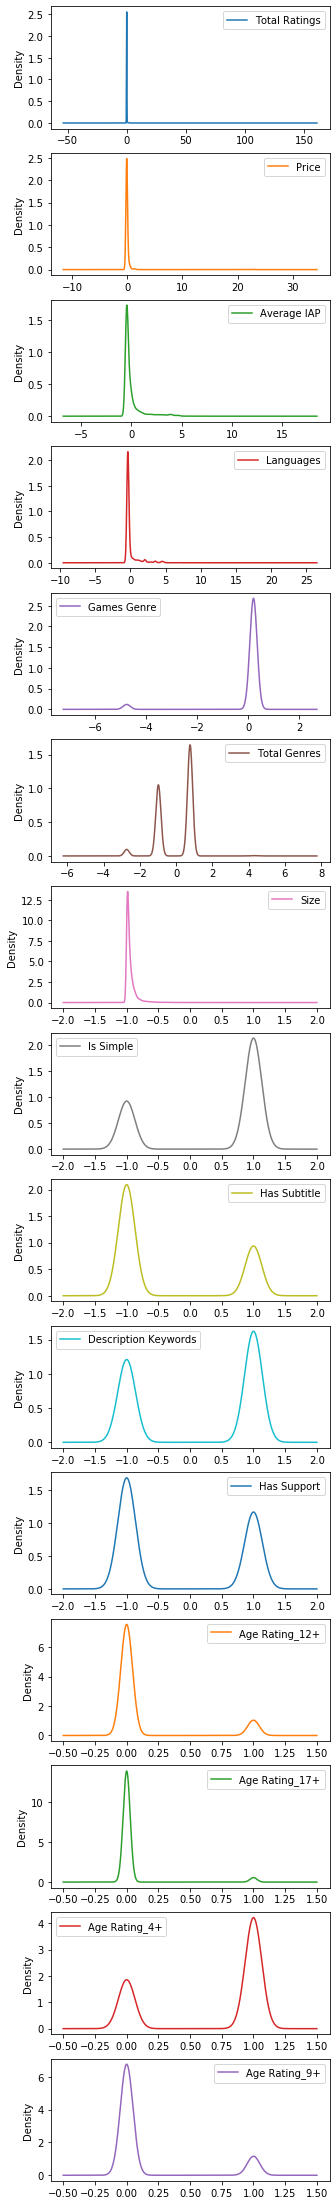

In [11]:
# Plotting Density Plots for each feature to understand the distribution
# https://machinelearningmastery.com/visualize-machine-learning-data-python-pandas/
df_ohe.plot(kind='density', subplots=True, layout=(15,1), sharex=False, figsize=(5,40))
plt.show()

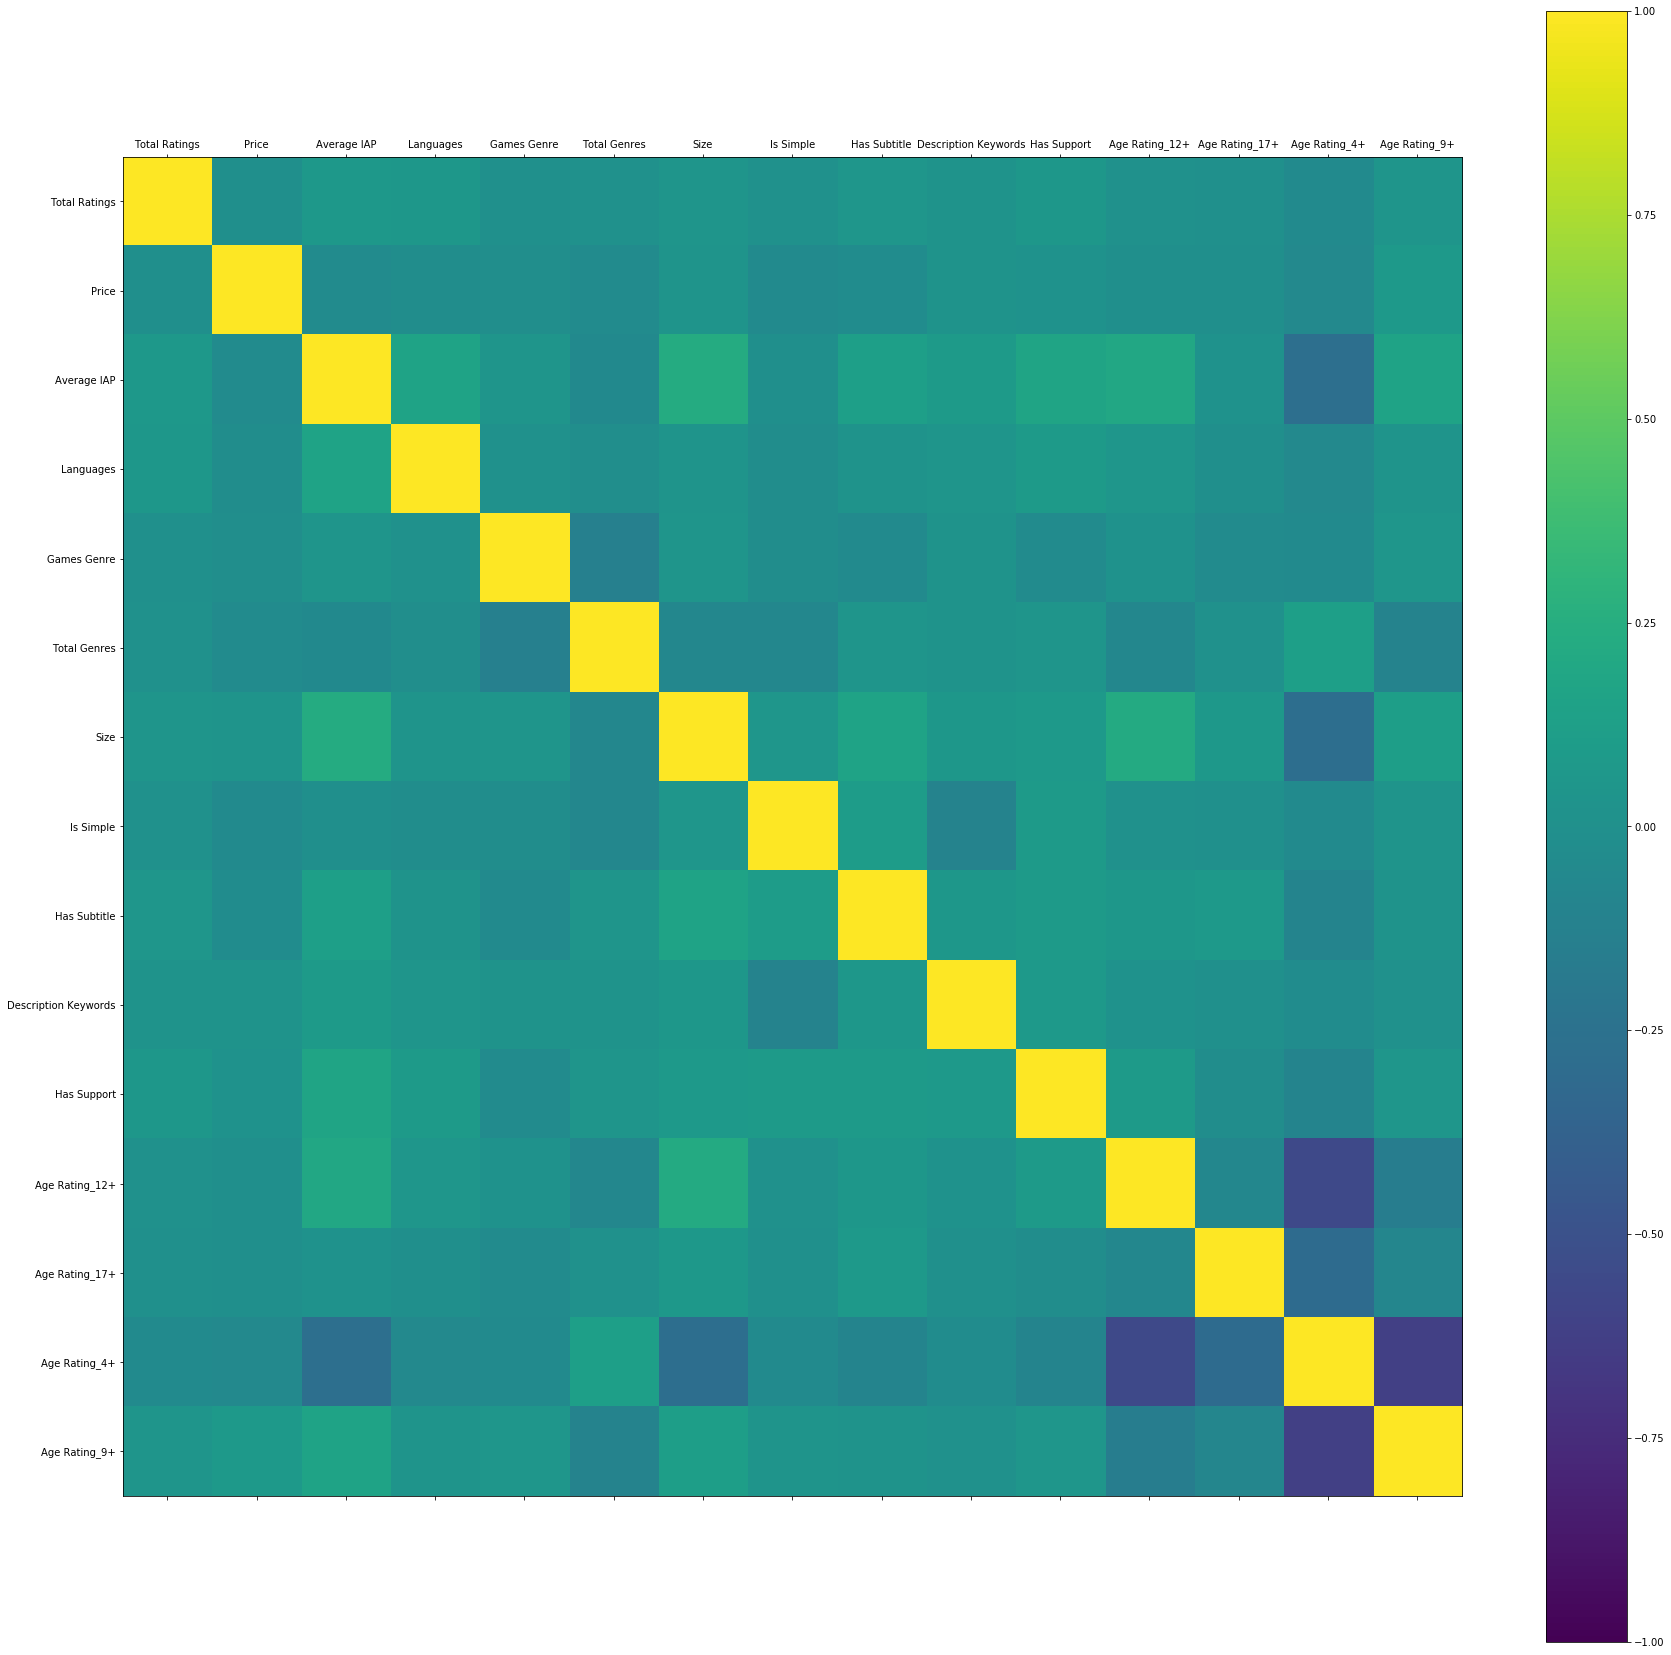

In [12]:
# Look at the Correlation Matrix. Code insspired from:
# https://machinelearningmastery.com/visualize-machine-learning-data-python-pandas/
figure = plt.figure(figsize=(30, 30))
ax = figure.add_subplot(1,1,1)
cax = ax.matshow(df_ohe.corr(), vmin=-1, vmax=1)
figure.colorbar(cax)
ticks = np.arange(0, 15, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
# Setup the names
feature_names = [name for name in df_ohe]
ax.set_xticklabels(feature_names)
ax.set_yticklabels(feature_names)
plt.show()

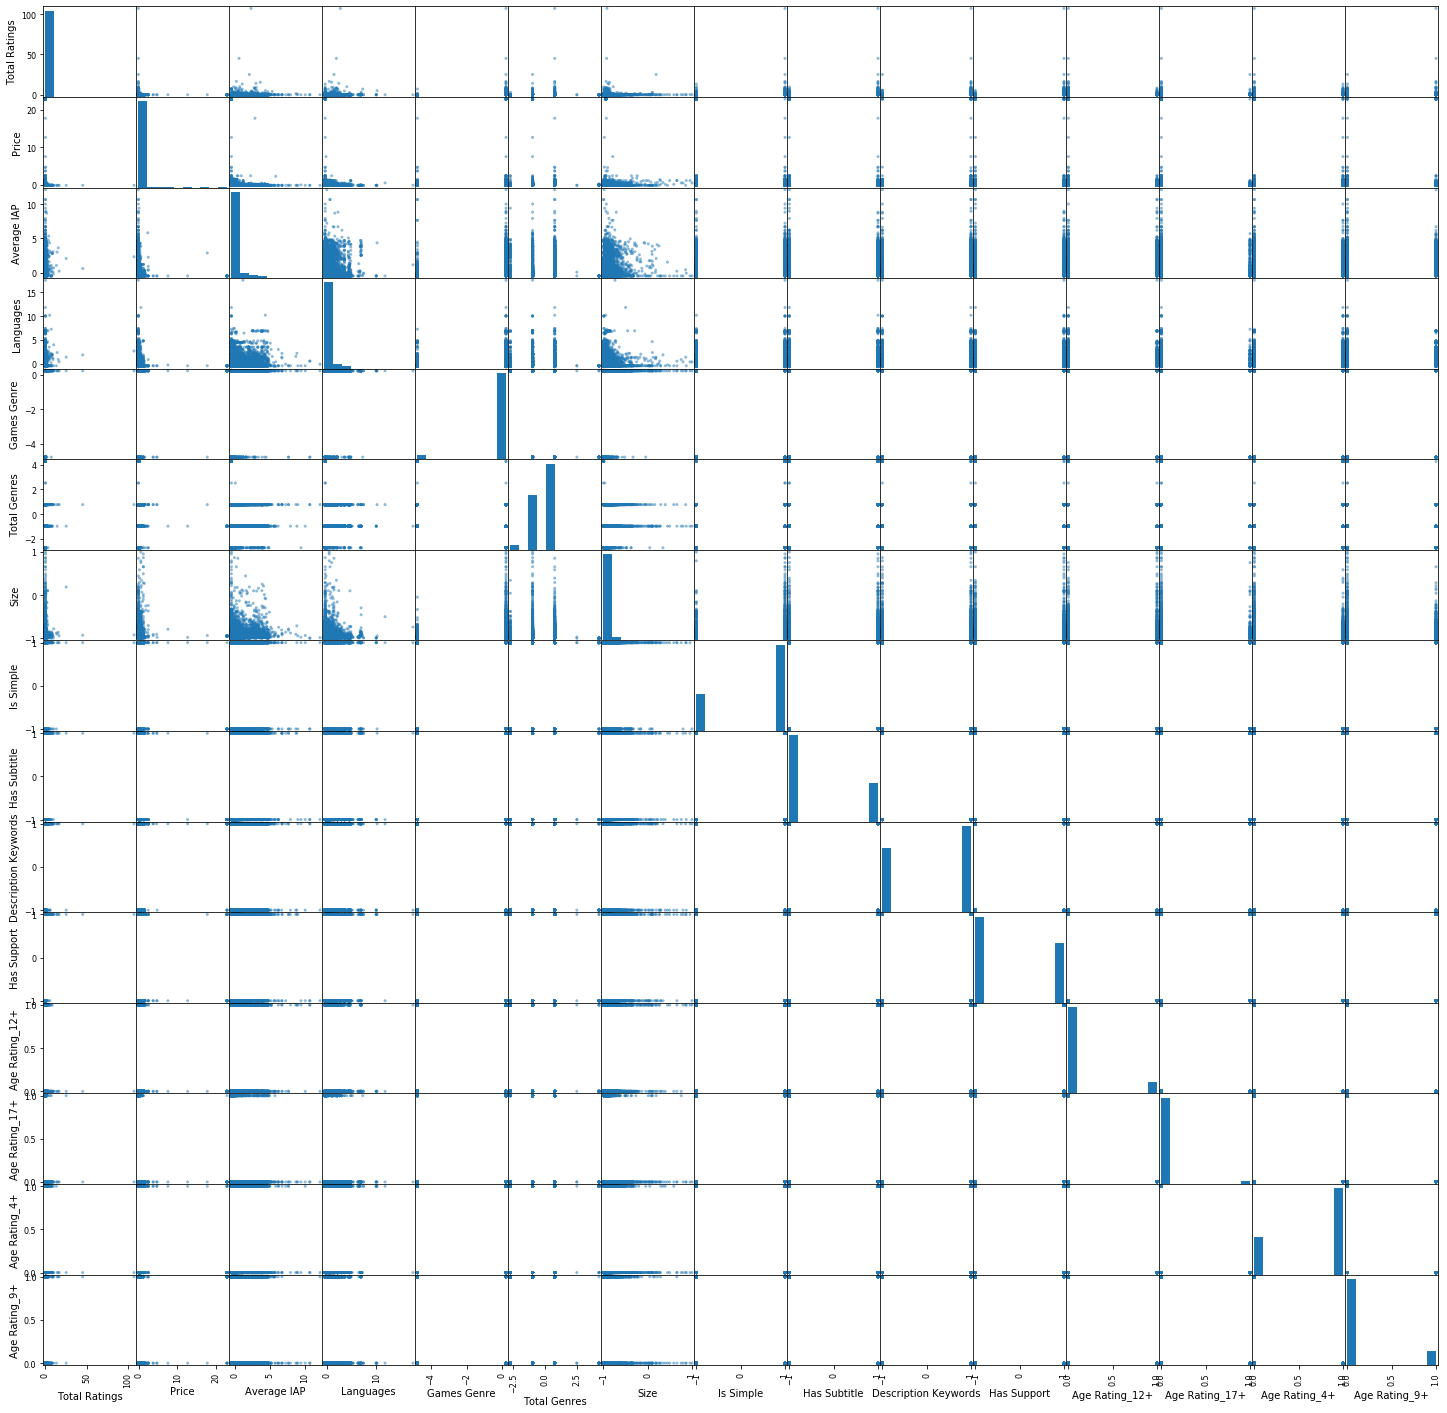

In [13]:
# Finally, look at the scatter plots
scatter_matrix(df_ohe, figsize=(25, 25))
plt.show()

Download    5573
Ignore      1988
Name: Average User Rating, dtype: int64


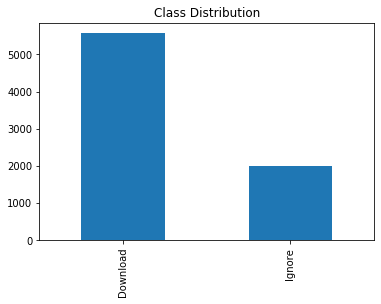

In [11]:
# Look at the class distribution to see the distribution
label_counts = df_ohe["Average User Rating"].value_counts()
label_counts.plot(kind="bar", title='Class Distribution')
print(label_counts)

**3. Sampling the data**    
We notice that Startegy games are typically rated a high score on the App Store. Thus, it will important to balance the class distribution via several sampling techniques, determining which performs best.

In [12]:
# Before doing this, we need to remove any NaN class values
# We will leave them in the original in case we want to work with them later
df_full = df_ohe[pd.notnull(df_ohe['Average User Rating'])]

In [13]:
# Setup our features and labels
y = df_full.pop("Average User Rating")
X = df_full

In [14]:
# To look into the sampled class label distribution
def barPlot(classes, counts, title):
    figure = plt.figure()
    ax = figure.add_axes([0, 0, 1, 1])
    ax.set_title(title)
    ax.bar([str(cl) for cl in classes], counts)
    plt.show()
    for cl, count in zip(classes, counts):
        print("Class:", cl, "contains", count, "total instances.")

***3.1 Oversampling***

In [15]:
smote = SMOTE(random_state=0, ratio="minority")
X_os, y_os = smote.fit_sample(X, y)

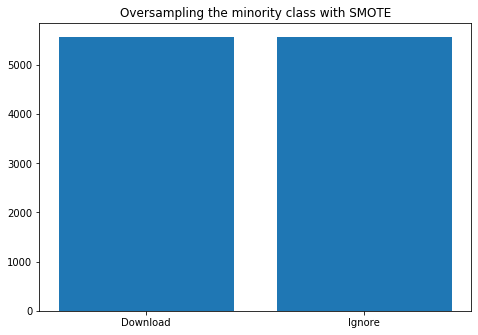

Class: Download contains 5573 total instances.
Class: Ignore contains 5573 total instances.


In [16]:
# Display the oversampling results
targets, counts = np.unique(y_os, return_counts=True)
barPlot(targets, counts, "Oversampling the minority class with SMOTE")

***3.2 Undersampling***

In [17]:
# Undersampling the majority class 0 using Tomek Links
# Note that there is insufficient time to compare undersampling techniques and we
# will thus use this technique as the undersampling baseline
tomek_links = TomekLinks(random_state=1, ratio='majority')
X_us, y_us = tomek_links.fit_sample(X, y)

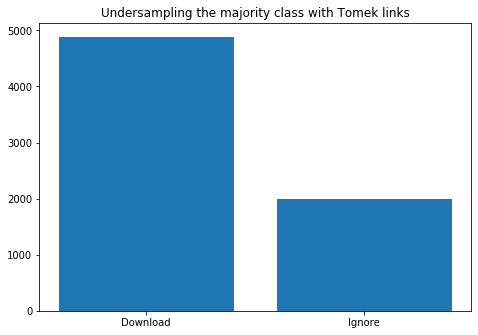

Class: Download contains 4891 total instances.
Class: Ignore contains 1988 total instances.


In [18]:
# Display the undersampling results
targets, counts = np.unique(y_us, return_counts=True)
barPlot(targets, counts, "Undersampling the majority class with Tomek links")

***3.3 Balanced Sampling***

In [19]:
# Perform Balanced sampling with imblearn's SMOTETomek
smote_tomek = SMOTETomek(random_state=1, ratio="auto")
X_bal, y_bal = smote_tomek.fit_sample(X, y)

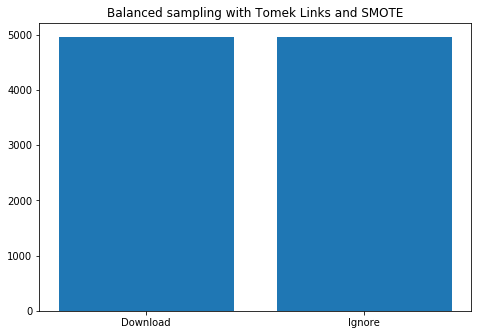

Class: Download contains 4964 total instances.
Class: Ignore contains 4964 total instances.


In [20]:
# Display the balance sampling results
targets, counts = np.unique(y_bal, return_counts=True)
barPlot(targets, counts, "Balanced sampling with Tomek Links and SMOTE")

In [21]:
# Setup lists with all of the sampling techniques to use for testing
X_sampling = [X_os, X_us, X_bal]
y_sampling = [y_os, y_us, y_bal]
sampling_types = ["Oversampling", "Undersampling", "Balanced Sampling"]

**4. Performance analysis and parameter tuning**   
In this section we will explore using a linear classifier (SVM), a tree-based algorithm, a distance-based algorithm, a rule-based algorithm, and an ensemble-based algorithm to predict the class label for the dataset.  
We will optimize each algorithm, looking at the best hyperparameter tuning possible and select our sampling techniques and hyperparameter setup for each algorithm to perform statistical testing on and to complete the remainder of the project.

Now we will perform 10-fold cross validation on all necessary algorithms to view which values the hyperparameters should contain to optimize the performance (accuracy, precision, recall tradeoff).

In [78]:
# Use cross-validation to train a model and receive the confusion matrices and accuracy at
# each fold. Also returns an averaged accuracy
# https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833
def cross_val(clf, X, y, folds=10):
    kf = KFold(n_splits=folds, random_state=1)
    scores = []
    precisions = []
    recalls = []
    f1_scores = []
    confusion_matrices = []
    for train_index, test_index in kf.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        confusion_matrices.append(confusion_matrix(y_test, y_pred))
        scores.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, pos_label="Download"))
        recalls.append(recall_score(y_test, y_pred, pos_label="Download"))
        f1_scores.append(f1_score(y_test, y_pred, pos_label="Download"))
    averaged_score = sum(scores) / len(scores)
    averaged_precision = sum(precisions) / len(precisions)
    averaged_recall = sum(recalls) / len(recalls)
    averaged_f1 = sum(f1_scores) / len(f1_scores)
    return scores, averaged_score, averaged_precision, averaged_recall, averaged_f1

***4.1 Decision Tree optimization for Tree-based algorithm***

In [81]:
# Tree-based model - Decision Tress
for X, y, sampling_type in zip(X_sampling, y_sampling, sampling_types):
    for max_depth in [2, 5, 10, 15, 20, 45, 50, 80, None]:
        for criterion in ["gini", "entropy"]:
            dt = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=1)
            scores_dt, avg_score, avg_precision, avg_recall, avg_f1  = cross_val(dt, X, y)
            print(sampling_type, "-  Max Depth =", max_depth, ", Criterion =", criterion, ", Accuracy =", avg_score, ", Precision =", avg_precision, ", Recall =", avg_recall, ", F1-Score =", avg_f1)
        print()

Oversampling -  Max Depth = 2 , Criterion = gini , Accuracy = 0.4904803117276247 , Precision = 0.5798080248132874 , Recall = 0.2889017281618841 , F1-Score = 0.38515653725274934
Oversampling -  Max Depth = 2 , Criterion = entropy , Accuracy = 0.4904803117276247 , Precision = 0.5798080248132874 , Recall = 0.2889017281618841 , F1-Score = 0.38515653725274934

Oversampling -  Max Depth = 5 , Criterion = gini , Accuracy = 0.5876629284040866 , Precision = 0.6056108304926355 , Recall = 0.33984079949805157 , F1-Score = 0.43430844675631175
Oversampling -  Max Depth = 5 , Criterion = entropy , Accuracy = 0.5845296310310681 , Precision = 0.6075730919345228 , Recall = 0.318917563037478 , F1-Score = 0.4178629929519907

Oversampling -  Max Depth = 10 , Criterion = gini , Accuracy = 0.6579231308016198 , Precision = 0.5884034776578448 , Recall = 0.41612868135291725 , F1-Score = 0.48684412686475154
Oversampling -  Max Depth = 10 , Criterion = entropy , Accuracy = 0.6413217025867275 , Precision = 0.58734

Balanced Sampling -  Max Depth = 45 , Criterion = gini , Accuracy = 0.7230148336744306 , Precision = 0.5901405669283885 , Recall = 0.5062277070289213 , F1-Score = 0.5438199149134303
Balanced Sampling -  Max Depth = 45 , Criterion = entropy , Accuracy = 0.7228164693174804 , Precision = 0.5918445060661879 , Recall = 0.5001370136586147 , F1-Score = 0.541094263096452

Balanced Sampling -  Max Depth = 50 , Criterion = gini , Accuracy = 0.7226120139362635 , Precision = 0.5901802268052843 , Recall = 0.5055680764220611 , F1-Score = 0.5434337326014289
Balanced Sampling -  Max Depth = 50 , Criterion = entropy , Accuracy = 0.7223129446447716 , Precision = 0.5918598663170367 , Recall = 0.49934545693038246 , F1-Score = 0.540617552885298

Balanced Sampling -  Max Depth = 80 , Criterion = gini , Accuracy = 0.7226120139362635 , Precision = 0.5901802268052843 , Recall = 0.5055680764220611 , F1-Score = 0.5434337326014289
Balanced Sampling -  Max Depth = 80 , Criterion = entropy , Accuracy = 0.7228164693

***4.2 kNN optimization (weighted and uniformly weighted) for Distance-based algorithm***

In [148]:
# Optimize kNN based on a distance metric and k
for X, y, sampling_type in zip(X_sampling, y_sampling, sampling_types):
    for weight_type in ["uniform", "distance"]:
        for metric in ["euclidean", "manhattan", "chebyshev"]:
            for k in [1, 3, 5, 7]:
                knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weight_type)
                scores_knn, avg_score, avg_precision, avg_recall, avg_f1 = cross_val(knn, X, y)
                print(sampling_type, " - Weighting type:",  weight_type, ", Distance metric =", metric, ", k =", k, ", Accuracy =", avg_score, ", Precision =", avg_precision, ", Recall =", avg_recall, ", F1-Score =", avg_f1)
            print()

Oversampling  - Weighting type: uniform , Distance metric = euclidean , k = 1 , Accuracy = 0.7479145164276916 , Precision = 0.6129342553370993 , Recall = 0.4848942617915021 , F1-Score = 0.541190116873153
Oversampling  - Weighting type: uniform , Distance metric = euclidean , k = 3 , Accuracy = 0.7044894574554589 , Precision = 0.5994138200487078 , Recall = 0.453300313002018 , F1-Score = 0.5159438581511033
Oversampling  - Weighting type: uniform , Distance metric = euclidean , k = 5 , Accuracy = 0.6862760142016409 , Precision = 0.5951913946770822 , Recall = 0.4378148122480341 , F1-Score = 0.5040558155685904
Oversampling  - Weighting type: uniform , Distance metric = euclidean , k = 7 , Accuracy = 0.6750612264614244 , Precision = 0.5956268908192219 , Recall = 0.4249688210698904 , F1-Score = 0.4954920960241639

Oversampling  - Weighting type: uniform , Distance metric = manhattan , k = 1 , Accuracy = 0.7532968899694874 , Precision = 0.612378815897958 , Recall = 0.4944138510984546 , F1-Scor

Undersampling  - Weighting type: distance , Distance metric = manhattan , k = 1 , Accuracy = 0.7392067380928201 , Precision = 0.8105305234433653 , Recall = 0.8265930739262742 , F1-Score = 0.8182452109404365
Undersampling  - Weighting type: distance , Distance metric = manhattan , k = 3 , Accuracy = 0.7405136082055449 , Precision = 0.798962276636843 , Recall = 0.8489294382049639 , F1-Score = 0.8229462231946838
Undersampling  - Weighting type: distance , Distance metric = manhattan , k = 5 , Accuracy = 0.7428394011712536 , Precision = 0.7940488080405086 , Recall = 0.8618440160285644 , F1-Score = 0.8264398119362506
Undersampling  - Weighting type: distance , Distance metric = manhattan , k = 7 , Accuracy = 0.7467672049016622 , Precision = 0.7912787953605498 , Recall = 0.8748857928458905 , F1-Score = 0.8307642591158204

Undersampling  - Weighting type: distance , Distance metric = chebyshev , k = 1 , Accuracy = 0.7408076910057207 , Precision = 0.8107348949445345 , Recall = 0.82922764703393

***4.3 Linear and non-linear SVM for Linerar Classifier***   
We use the various types of SVMs to contrast against the linear classifier and better the performance of SVM kernels.

In [28]:
# Maybe decision_function_shape rather than tol
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
for X, y, sampling_type in zip(X_sampling, y_sampling, sampling_types):
    for kernel in ["linear", "poly", "rbf", "sigmoid"]:
        for gamma in ["auto", "scale"]:
            for tol in [0.001]: #[0.1, 0.01, 0.001, 0.0001, 0.00001]:
                if kernel == "poly":
                    for degree in [2, 3, 4, 5]:
                        svm = SVC(kernel=kernel, gamma=gamma, tol=tol, degree=degree, random_state=1)
                        scores_svm, avg_score, avg_precision, avg_recall, avg_f1 = cross_val(svm, X, y)
                        print(sampling_type, "-  Degree =", degree, ", Kernel =", kernel, ", Gamma =", gamma, ", Tol =", tol, ", Accuracy =", avg_score, ", Precision =", avg_precision, ", Recall =", avg_recall, ", F1-Score =", avg_f1)
                else:
                    svm = SVC(kernel=kernel, gamma=gamma, tol=tol, random_state=1)
                    scores_svm, avg_score, avg_precision, avg_recall, avg_f1 = cross_val(svm, X, y)
                    print(sampling_type, "-  Kernel =", kernel, ", Gamma =", gamma, ", Tol =", tol, ", Accuracy =", avg_score, ", Precision =", avg_precision, ", Recall =", avg_recall, ", F1-Score =", avg_f1)
    print()

Oversampling -  Kernel = linear , Gamma = auto , Tol = 0.001 , Accuracy = 0.6016113709735852 , Precision = 0.5790409475456502 , Recall = 0.2889017281618841 , F1-Score = 0.38494208039507066
Oversampling -  Kernel = linear , Gamma = scale , Tol = 0.001 , Accuracy = 0.6016113709735852 , Precision = 0.5790409475456502 , Recall = 0.2889017281618841 , F1-Score = 0.38494208039507066
Oversampling -  Degree = 2 , Kernel = poly , Gamma = auto , Tol = 0.001 , Accuracy = 0.5797904372398579 , Precision = 0.5776693436887242 , Recall = 0.30978072496423403 , F1-Score = 0.4020362868386667
Oversampling -  Degree = 3 , Kernel = poly , Gamma = auto , Tol = 0.001 , Accuracy = 0.5842687845681944 , Precision = 0.5862561966662772 , Recall = 0.3284445085258283 , F1-Score = 0.41963481101517675
Oversampling -  Degree = 4 , Kernel = poly , Gamma = auto , Tol = 0.001 , Accuracy = 0.5917139383790484 , Precision = 0.5894402633105559 , Recall = 0.3383855905207435 , F1-Score = 0.4284762354390817
Oversampling -  Degree

***4.4 Decision Stump for Rule-based Classifier***   

In [24]:
# Using the DummyClassifier (Decision Stump, rule-based)
for X, y, sampling_type in zip(X_sampling, y_sampling, sampling_types):
    for strategy in ["stratified", "most_frequent", "prior", "uniform"]:
        ds = DummyClassifier(strategy=strategy, random_state=1)
        scores_rule, avg_score, avg_precision, avg_recall, avg_f1 = cross_val(ds, X, y)
        print(sampling_type, "- Strategy =", strategy, ", Accuracy =", avg_score, ", Precision =", avg_precision, ", Recall =", avg_recall, ", F1-Score =", avg_f1)
    print()

Oversampling - Strategy = stratified , Accuracy = 0.4772953281110368 , Precision = 0.4960510273207466 , Recall = 0.33771483634004623 , F1-Score = 0.40080948996727594
Oversampling - Strategy = most_frequent , Accuracy = 0.200128410527248 , Precision = 0.0 , Recall = 0.0 , F1-Score = 0.0
Oversampling - Strategy = prior , Accuracy = 0.200128410527248 , Precision = 0.0 , Recall = 0.0 , F1-Score = 0.0
Oversampling - Strategy = uniform , Accuracy = 0.5021475553694923 , Precision = 0.5018224048597463 , Recall = 0.365485598639036 , F1-Score = 0.42213312434483397

Undersampling - Strategy = stratified , Accuracy = 0.5692677126705258 , Precision = 0.7016563271617816 , Recall = 0.6860066116017111 , F1-Score = 0.6935950163612092
Undersampling - Strategy = most_frequent , Accuracy = 0.7110012355709016 , Precision = 0.7110012355709016 , Recall = 1.0 , F1-Score = 0.8309641808195517
Undersampling - Strategy = prior , Accuracy = 0.7110012355709016 , Precision = 0.7110012355709016 , Recall = 1.0 , F1-Sc

***4.5 Random forests for Ensermble Classifiers***

In [29]:
# Compare forest size, gini vs entropy
for X, y, sampling_type in zip(X_sampling, y_sampling, sampling_types):
    for estimators in [50, 100, 200, 500, 1000]:
        for max_depth in [2, 5, 10, 15, 20, 45, 50, 80, None]:
            for criterion in ["gini", "entropy"]:
                rf = RandomForestClassifier(n_estimators=estimators, max_depth=max_depth, criterion=criterion, random_state=1)
                scores_rf, avg_score, avg_precision, avg_recall, avg_f1 = cross_val(rf, X, y)
                print(sampling_type, "-  Estimators =", estimators, ", Max Depth =", max_depth, ",  Criterion =", criterion, ", Accuracy =", avg_score, ", Precision =", avg_precision, ", Recall =", avg_recall, ", F1-Score =", avg_f1)
        print()

Oversampling -  Estimators = 50 , Max Depth = 2 ,  Criterion = gini , Accuracy = 0.513077827245574 , Precision = 0.6055686768053171 , Recall = 0.3240553175826001 , F1-Score = 0.4209250965314707
Oversampling -  Estimators = 50 , Max Depth = 2 ,  Criterion = entropy , Accuracy = 0.5132581655408941 , Precision = 0.6064182524092964 , Recall = 0.3210981643919851 , F1-Score = 0.41880217337118086
Oversampling -  Estimators = 50 , Max Depth = 5 ,  Criterion = gini , Accuracy = 0.5952921238859682 , Precision = 0.6076779759600365 , Recall = 0.34564097651505743 , F1-Score = 0.4397218716438268
Oversampling -  Estimators = 50 , Max Depth = 5 ,  Criterion = entropy , Accuracy = 0.5965488563814799 , Precision = 0.607162084245213 , Recall = 0.34697549646129333 , F1-Score = 0.44065719999072017
Oversampling -  Estimators = 50 , Max Depth = 10 ,  Criterion = gini , Accuracy = 0.6934602410414537 , Precision = 0.6185593513067358 , Recall = 0.4159491044446194 , F1-Score = 0.4967207701283599
Oversampling -  

Oversampling -  Estimators = 200 , Max Depth = 15 ,  Criterion = gini , Accuracy = 0.7548287993816972 , Precision = 0.6168218271794867 , Recall = 0.48296070144866754 , F1-Score = 0.5413275047915082
Oversampling -  Estimators = 200 , Max Depth = 15 ,  Criterion = entropy , Accuracy = 0.7495364339712264 , Precision = 0.6167460882396625 , Recall = 0.4766592957252308 , F1-Score = 0.5372571660032919
Oversampling -  Estimators = 200 , Max Depth = 20 ,  Criterion = gini , Accuracy = 0.782547439437731 , Precision = 0.6163760872841519 , Recall = 0.523120606281451 , F1-Score = 0.5656388241360555
Oversampling -  Estimators = 200 , Max Depth = 20 ,  Criterion = entropy , Accuracy = 0.7807550861034852 , Precision = 0.6164211535219505 , Recall = 0.515753437406571 , F1-Score = 0.5613163418876672
Oversampling -  Estimators = 200 , Max Depth = 45 ,  Criterion = gini , Accuracy = 0.7875675262255356 , Precision = 0.6102966008694631 , Recall = 0.5403266317177202 , F1-Score = 0.572958832410645
Oversampling

Oversampling -  Estimators = 1000 , Max Depth = 50 ,  Criterion = gini , Accuracy = 0.7899911441015692 , Precision = 0.6109802804845538 , Recall = 0.5399202405286123 , F1-Score = 0.5730044047360501
Oversampling -  Estimators = 1000 , Max Depth = 50 ,  Criterion = entropy , Accuracy = 0.7918755987794961 , Precision = 0.612337093461831 , Recall = 0.5404791863182971 , F1-Score = 0.5739249928338788
Oversampling -  Estimators = 1000 , Max Depth = 80 ,  Criterion = gini , Accuracy = 0.7899911441015692 , Precision = 0.6109802804845538 , Recall = 0.5399202405286123 , F1-Score = 0.5730044047360501
Oversampling -  Estimators = 1000 , Max Depth = 80 ,  Criterion = entropy , Accuracy = 0.7918755987794961 , Precision = 0.612337093461831 , Recall = 0.5404791863182971 , F1-Score = 0.5739249928338788
Oversampling -  Estimators = 1000 , Max Depth = None ,  Criterion = gini , Accuracy = 0.7899911441015692 , Precision = 0.6109802804845538 , Recall = 0.5399202405286123 , F1-Score = 0.5730044047360501
Over

Undersampling -  Estimators = 200 , Max Depth = 2 ,  Criterion = gini , Accuracy = 0.7110012355709016 , Precision = 0.7110012355709016 , Recall = 1.0 , F1-Score = 0.8309641808195517
Undersampling -  Estimators = 200 , Max Depth = 2 ,  Criterion = entropy , Accuracy = 0.7110012355709016 , Precision = 0.7110012355709016 , Recall = 1.0 , F1-Score = 0.8309641808195517
Undersampling -  Estimators = 200 , Max Depth = 5 ,  Criterion = gini , Accuracy = 0.720304619004096 , Precision = 0.7208092653339342 , Recall = 0.99013978304816 , F1-Score = 0.834132522597755
Undersampling -  Estimators = 200 , Max Depth = 5 ,  Criterion = entropy , Accuracy = 0.7189962678988524 , Precision = 0.7188011718647849 , Recall = 0.9934308439405507 , F1-Score = 0.8339481954896074
Undersampling -  Estimators = 200 , Max Depth = 10 ,  Criterion = gini , Accuracy = 0.7442916201211875 , Precision = 0.7495211139807058 , Recall = 0.9617169223469265 , F1-Score = 0.8423260187651408
Undersampling -  Estimators = 200 , Max De

Undersampling -  Estimators = 1000 , Max Depth = 15 ,  Criterion = gini , Accuracy = 0.7524339054195863 , Precision = 0.7670035908134596 , Recall = 0.9359672260392934 , F1-Score = 0.8429989441172301
Undersampling -  Estimators = 1000 , Max Depth = 15 ,  Criterion = entropy , Accuracy = 0.753014666057344 , Precision = 0.7654848375672053 , Recall = 0.9406184414109152 , F1-Score = 0.8439502030839746
Undersampling -  Estimators = 1000 , Max Depth = 20 ,  Criterion = gini , Accuracy = 0.75185124064859 , Precision = 0.7752927360550821 , Recall = 0.9165240531361478 , F1-Score = 0.8398832602828211
Undersampling -  Estimators = 1000 , Max Depth = 20 ,  Criterion = entropy , Accuracy = 0.7515603314038116 , Precision = 0.7736072789255954 , Recall = 0.9196319160218073 , F1-Score = 0.8402048540296068
Undersampling -  Estimators = 1000 , Max Depth = 45 ,  Criterion = gini , Accuracy = 0.7546122338444873 , Precision = 0.7789031518457834 , Recall = 0.9145112572121803 , F1-Score = 0.841114565367809
Und

Balanced Sampling -  Estimators = 100 , Max Depth = 45 ,  Criterion = entropy , Accuracy = 0.8283751380632166 , Precision = 0.6305820360372044 , Recall = 0.5692322554692496 , F1-Score = 0.5978867856251127
Balanced Sampling -  Estimators = 100 , Max Depth = 50 ,  Criterion = gini , Accuracy = 0.82837452896079 , Precision = 0.6298774140449334 , Recall = 0.5711408421237975 , F1-Score = 0.5985771852757237
Balanced Sampling -  Estimators = 100 , Max Depth = 50 ,  Criterion = entropy , Accuracy = 0.8283751380632166 , Precision = 0.6305820360372044 , Recall = 0.5692322554692496 , F1-Score = 0.5978867856251127
Balanced Sampling -  Estimators = 100 , Max Depth = 80 ,  Criterion = gini , Accuracy = 0.82837452896079 , Precision = 0.6298774140449334 , Recall = 0.5711408421237975 , F1-Score = 0.5985771852757237
Balanced Sampling -  Estimators = 100 , Max Depth = 80 ,  Criterion = entropy , Accuracy = 0.8283751380632166 , Precision = 0.6305820360372044 , Recall = 0.5692322554692496 , F1-Score = 0.59

Balanced Sampling -  Estimators = 500 , Max Depth = None ,  Criterion = gini , Accuracy = 0.8298848999447748 , Precision = 0.6334856976040569 , Recall = 0.5696918014255168 , F1-Score = 0.5993400845585652
Balanced Sampling -  Estimators = 500 , Max Depth = None ,  Criterion = entropy , Accuracy = 0.8310946788812007 , Precision = 0.6334788712576909 , Recall = 0.5691510841467047 , F1-Score = 0.59912509499821

Balanced Sampling -  Estimators = 1000 , Max Depth = 2 ,  Criterion = gini , Accuracy = 0.5457142538089205 , Precision = 0.6072982236400895 , Recall = 0.3478357086821223 , F1-Score = 0.4374660679185041
Balanced Sampling -  Estimators = 1000 , Max Depth = 2 ,  Criterion = entropy , Accuracy = 0.5456137519085209 , Precision = 0.6072963112825389 , Recall = 0.34770182987755377 , F1-Score = 0.43724329731801176
Balanced Sampling -  Estimators = 1000 , Max Depth = 5 ,  Criterion = gini , Accuracy = 0.6252044553812169 , Precision = 0.6120257112225597 , Recall = 0.3866184555210038 , F1-Score 

***4.6 Gaussian Naive Bayes optimization for Bayesian algorithm***

In [84]:
'''
# Multinomial Naive Bayes
for X, y, sampling_type in zip(X_sampling, y_sampling, sampling_types):
    nb = MultinomialNB(alpha=0.1)
    scores_nb, avg_score, avg_precision, avg_recall, avg_f1 = cross_val(nb, X, y)
    print(sampling_type, "-  Multinomial Naive Bayes Accuracy:", avg_score, ", Precision =", avg_precision, ", Recall =", avg_recall)
'''
# Gaussian Naive Bayes
for X, y, sampling_type in zip(X_sampling, y_sampling, sampling_types):
    gnb = GaussianNB()
    scores_gnb, avg_score, avg_precision, avg_recall, avg_f1 = cross_val(gnb, X, y)
    print(sampling_type, "-  Gaussian Naive Bayes Accuracy:", avg_score, ", Precision =", avg_precision, ", Recall =", avg_recall, ", F1-Score =", avg_f1)

Oversampling -  Gaussian Naive Bayes Accuracy: 0.544052620138313 , Precision = 0.5632472954944964 , Recall = 0.14849816573128033 , F1-Score = 0.23327327014364138
Undersampling -  Gaussian Naive Bayes Accuracy: 0.4983294404387123 , Precision = 0.807653566890278 , Recall = 0.3859945130459076 , F1-Score = 0.5190297619293499
Balanced Sampling -  Gaussian Naive Bayes Accuracy: 0.5531430700386577 , Precision = 0.5724884741159487 , Recall = 0.16544348597668113 , F1-Score = 0.2560901509993285


***4.7 Ada-Boosting the Bayesian algorithm***   
The Bayesian algorithm gave poor results. This is to be expected as discussed later, but although a little better than a weak learner (by definition), I want to experiment with a Boosting technique on the algorithm.

In [85]:
'''
# Since Naive Bayes performed poorly, try with ada boostnb = MultinomialNB(alpha=0.1)
for X, y, sampling_type in zip(X_sampling, y_sampling, sampling_types):
    for n_estimators in [25, 50, 100, 200]:
        nb = MultinomialNB(alpha=0.1)
        ab_nb = AdaBoostClassifier(nb, n_estimators=n_estimators, random_state=1)
        scores_ab_nb, avg_score, avg_precision, avg_recall, avg_f1 = cross_val(ab_nb, X, y)
        print(sampling_type, "-  Ada Boosted Multinomial Naive Bayes Accuracy:", avg_score, ", Precision =", avg_precision, ", Recall =", avg_recall)

print()
'''

for X, y, sampling_type in zip(X_sampling, y_sampling, sampling_types):
    for n_estimators in [25, 50, 100, 200]:
        gnb = GaussianNB()
        ab_gnb = AdaBoostClassifier(gnb, n_estimators=n_estimators, random_state=1)
        scores_ab_gnb, avg_score, avg_precision, avg_recall, avg_f1 = cross_val(ab_gnb, X, y)
        print(sampling_type, "-  Ada Boosted Gaussian Naive Bayes Accuracy:", avg_score, ", Precision =", avg_precision, ", Recall =", avg_recall, ", F1-Score =", avg_f1)

Oversampling -  Ada Boosted Gaussian Naive Bayes Accuracy: 0.5914555071612015 , Precision = 0.49855860454573164 , Recall = 0.3785140420136445 , F1-Score = 0.40353792695105073
Oversampling -  Ada Boosted Gaussian Naive Bayes Accuracy: 0.5899896144463856 , Precision = 0.5016767044330174 , Recall = 0.29322299812322455 , F1-Score = 0.33035867019972365
Oversampling -  Ada Boosted Gaussian Naive Bayes Accuracy: 0.6273784930481197 , Precision = 0.5003932495044263 , Recall = 0.3935417985659562 , F1-Score = 0.4120506530646867
Oversampling -  Ada Boosted Gaussian Naive Bayes Accuracy: 0.4767024659651722 , Precision = 0.5183553878005865 , Recall = 0.28416825059229744 , F1-Score = 0.3234129055040856
Undersampling -  Ada Boosted Gaussian Naive Bayes Accuracy: 0.6057585220540942 , Precision = 0.7267892930270428 , Recall = 0.7354836372084523 , F1-Score = 0.6981474556718675
Undersampling -  Ada Boosted Gaussian Naive Bayes Accuracy: 0.4679458210622524 , Precision = 0.7129853991875912 , Recall = 0.4200

***4.6 Discussion of results***

From analyzing the outputs from all of the algorithms, the **undersampled data** provided the best overall results (with respect to the selected evaluation metrics). Although a lower oevrall accuracy than the Balanced Sampling dataset (which provided the highest accuracy), the precision and recall values, along with the f1-score, (based on the positive class, Download) exhibit that it performs much better in correctly identifying applications likely to be downloaded (which is what everyone wants to know). From the Balanced Sampling Dataset providing poor precision and recall on the majority class, we can say that oversampling the minority class causes the classifiers to overfocus on the artifically generated instances from SMOTE.   

To prove this, let's discuss the results. First, Balanced Sampling performed the best in terms of accuracy, but poor w.r.t. precision and recall on the majority class. This is an issue since we are interested in those results more so than better results on the minority class. The Oversampled dataset performs poorly as well at predicting the majority class. The Undersampled dataset provides lower overall accuracy with sometimes too high precision and recall (meaning mostly incorrectly classifying the minority class). But, some algorithms provide results that are fine to use given not too high precision and recall rates. It could be argued that Balanced Sampling is better, but the issue is that this project desires results for the majority class in a timely fashion. Thus, it should be noted that modified Balanced Sampling or different undersampling techniques could benefit the results.   

Finally, for each of the above models we will present the optimal hyperparameter setup for the undersampled dataset that  we will use for the remainder of the notebook.

***Decision Tree***   
Tested:    
1) max_depth: 2, 5, 10, 15, 20, 45, 50, 80, and no limit   
2) criterion: Gini index vs Entropy   
Best overall results w.r.t. Accuracy, Precision, Recall, and F1-Measure:
Undersampling -  Max Depth = 5 , Criterion = entropy , Accuracy = 0.7165268186588133 , Precision = 0.732920237125536 , Recall = 0.9465142128281194 , F1-Score = 0.8258689767599463   
Thus, we use: max_depth=5 and criterion="entropy" to get the optimal Decision Tree results   
Notes:   
Oddly, the accuracy decreases for the undersampled dataset as the max_depth increases, while the opposite is true for the Oversampled and Balanced Sampled datasets.    

***kNN***   
Tested:    
1) weight_type: Either uniform weights (kNN) or distance-based weights (weighted kNN)   
2) metric: Euclidean distance, Manhattan distance, and Chebyshev distance   
3) k: 1, 3, 5, and 7    
Best overall results w.r.t. Accuracy, Precision, Recall, and F1-Measure (very close between Eulidean, k=1,3,5, distance, and, manhattan k=7, distance:    
Undersampling  - Weighting type: distance , Distance metric = manhattan , k = 7 , Accuracy = 0.7467672049016622 , Precision = 0.7912787953605498 , Recall = 0.8748857928458905 , F1-Score = 0.8307642591158204    
Thus, we use: weights=distance, metric=manhattan, and k=7   
Best non-weighted is Euclidean with k=1   
Notes:   
1NN works the best when weights are uniform, but when the weights are distance-based, higher ks perform as well, if not better than 1NN.   

***SVM***     
Tested:    
1) kernel: linear, poly, rbf, and sigmoid    
2) gamma: auto vs scale   
3) degree (if kernel=poly): 2, 3, 4, 5    
Best overall results w.r.t. Accuracy, Precision, Recall, and F1-Measure:   
1) For linear kernel: gamma had no effect    
Undersampling -  Kernel = linear , Gamma = auto , Tol = 0.001 , Accuracy = 0.7110012355709016 , Precision = 0.7110012355709016 , Recall = 1.0 , F1-Score = 0.8309641808195517     
2) Overall best:     
Undersampling -  Degree = 5 , Kernel = poly , Gamma = auto , Tol = 0.001 , Accuracy = 0.71303823499543 , Precision = 0.7166103968596486 , Recall = 0.9865627218634032 , F1-Score = 0.8300616316809389    
Thus, we can  use a linear kernel for one, and a polynomial kernel of degree 5 with gamma=auto.    
Notes:    
The algorithm performed poorly on the Oversampled and Balance Sampled datasets    

***Dummy Classifier (Decision Stump)***    
Tested:    
1) strategy: stratified, most_frequent, prior, uniform    
Best overall results w.r.t. Accuracy, Precision, Recall, and F1-Measure:   
Undersampling - Strategy = most_frequent , Accuracy = 0.7110012355709016 , Precision = 0.7110012355709016 , Recall = 1.0 , F1-Score = 0.8309641808195517      
Undersampling - Strategy = prior , Accuracy = 0.7110012355709016 , Precision = 0.7110012355709016 , Recall = 1.0 , F1-Score = 0.8309641808195517     
Thus we use either Strategy=prior or strategy=most_frequent.    
Notes:   
This is a terrible, single-rule, algorithm that cannot classify well. Since we care about letting successful apps knowing that they will be successful, we will call the majority class prediction best despite knowing this means 0% of everything for the minority class will be taken. The wittgenstein algorithms, IREP and RIPPER, caused errors due to the maximum recursion depth being reached (cannot be fixed). Orange gacve issues with data loading that lead to the same most_frequent rule being used.

***Random forest***   
Tested:   
1) estimators: 50, 100, 200, 500, and 1000   
2) max_depth: 2, 5, 10, 15, 20, 45, 50, 80, and no limit   
3) criterion: gini vs entropy   
Best overall results w.r.t. Accuracy, Precision, Recall, and F1-Measure:   
Undersampling -  Estimators = 200 , Max Depth = 45 ,  Criterion = entropy , Accuracy = 0.7553400358823331 , Precision = 0.7794898790886251 , Recall = 0.9146936610217138 , F1-Score = 0.8415254609916095    
Thus, we use: estimators=200, max_depth=45, and criterion=entropy   
Notes:    
These tests provided the largest range of results, exhibiting the importance of parameter tuning. Balanced Sampling gave the highest accuracy recorded, but poor precision/recall. Any depth >= 45 gives the same results on the data.    

***Gaussian Naive Bayes***    
Undersampling -  Gaussian Naive Bayes Accuracy: 0.4983294404387123 , Precision = 0.807653566890278 , Recall = 0.3859945130459076 , F1-Score = 0.5190297619293499   

***Ada-boosted Gaussian Naive Bayes (weak learner):***    
Tested:    
1) n_estimators: 25, 50, 100, and 200    
Best overall results w.r.t. Accuracy, Precision, Recall, and F1-Measure:    
Undersampling -  Ada Boosted Gaussian Naive Bayes Accuracy: 0.6057585220540942 , Precision = 0.7267892930270428 , Recall = 0.7354836372084523 , F1-Score = 0.6981474556718675     
Thus, we use n_estimators=25

**5. Formal evaluation and Statistical Testing of Optimal Models on the optimial sampling set**   

***5.1 Running the algorithms and plotting their ROC curves***   
Idea on plotting ROC Curves from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

In [25]:
# Use cross-validation to train a model and receive the confusion matrices and accuracy at
# each fold. Also returns an averaged accuracy
# Now prepare ROC curve data as well
# https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833
def cross_val(clf, X, y, folds=10):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    kf = KFold(n_splits=folds, random_state=1)
    scores = []
    precisions = []
    recalls = []
    f1_scores = []
    confusion_matrices = []
    fold = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        confusion_matrices.append(confusion_matrix(y_test, y_pred))
        scores.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, pos_label="Download"))
        recalls.append(recall_score(y_test, y_pred, pos_label="Download"))
        f1_scores.append(f1_score(y_test, y_pred, pos_label="Download"))
        # ROC Curve code
        probabilities = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probabilities[:, 1], pos_label="Download")
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (fold, roc_auc))
        fold += 1
    # Display the ROC Curve
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    # Return the results
    averaged_score = sum(scores) / len(scores)
    averaged_precision = sum(precisions) / len(precisions)
    averaged_recall = sum(recalls) / len(recalls)
    averaged_f1 = sum(f1_scores) / len(f1_scores)
    return scores, averaged_score, averaged_precision, averaged_recall, averaged_f1

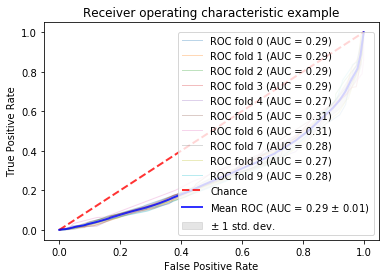

In [27]:
# Decision Tree
dt = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=1)
scores_dt, avg_score_dt, avg_precision_dt, avg_recall_dt, avg_f1_dt = cross_val(dt, X_us, y_us)

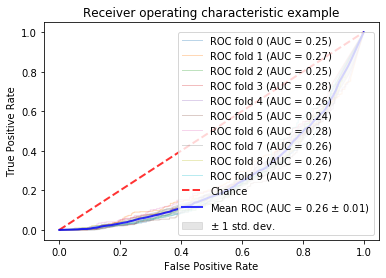

In [28]:
# kNN (weighted)
knn = KNeighborsClassifier(n_neighbors=7, metric="manhattan", weights="distance")
scores_knn, avg_score_knn, avg_precision_knn, avg_recall_knn, avg_f1_knn = cross_val(knn, X_us, y_us)

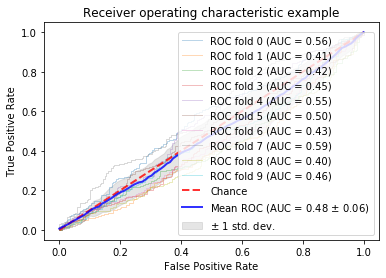

In [29]:
# Linear SVM
svml = SVC(kernel="linear", gamma="auto", tol=0.001, probability=True, random_state=1)
scores_svml, avg_score_svml, avg_precision_svml, avg_recall_svml, avg_f1_svml = cross_val(svml, X_us, y_us)

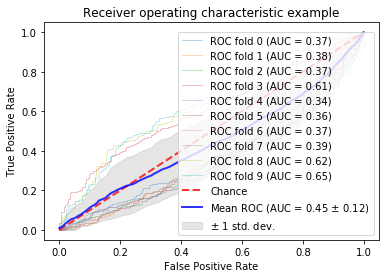

In [30]:
# Polynomial SVM
svmp = SVC(kernel="poly", gamma="auto", tol=0.001, degree=5, probability=True, random_state=1)
scores_svmp, avg_score_svmp, avg_precision_svmp, avg_recall_svmp, avg_f1_svmp = cross_val(svmp, X_us, y_us)

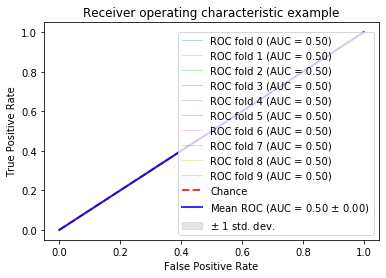

In [36]:
# Decision Stump
ds = DummyClassifier(strategy="most_frequent", random_state=1)
scores_ds, avg_score_ds, avg_precision_ds, avg_recall_ds, avg_f1_ds = cross_val(ds, X_us, y_us)

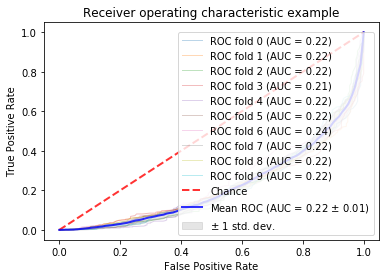

In [32]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=45, criterion="entropy", random_state=1)
scores_rf, avg_score_rf, avg_precision_rf, avg_recall_rf, avg_f1_rf = cross_val(rf, X_us, y_us)

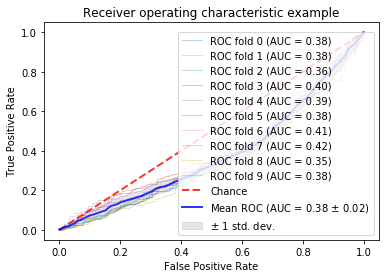

In [33]:
# Gaussian Naive Bayes
gnb = GaussianNB()
scores_gnb, avg_score_gnb, avg_precision_gnb, avg_recall_gnb, avg_f1_gnb = cross_val(gnb, X_us, y_us)

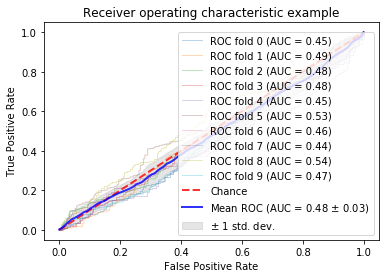

In [34]:
# Ada-boosted Gaussian Naive Bayes
gnb2 = GaussianNB()
ab_gnb = AdaBoostClassifier(gnb2, n_estimators=25, random_state=1)
scores_ab_gnb, avg_score_ab_gnb, avg_precision_ab_gnb, avg_recall_ab_gnb, avg_f1_ab_gnb = cross_val(ab_gnb, X_us, y_us)

Note that these ROC curves display the poor results from the minority class. But, as mentioned above, we expect this. We will choose the best solution from a variety of factors including the best, non-50/50 ROC curve. Understanding the problem and the cons of the chosen approach help understand the ROC curve and how we would go about improving it (by using different undersampling techniques in this case).

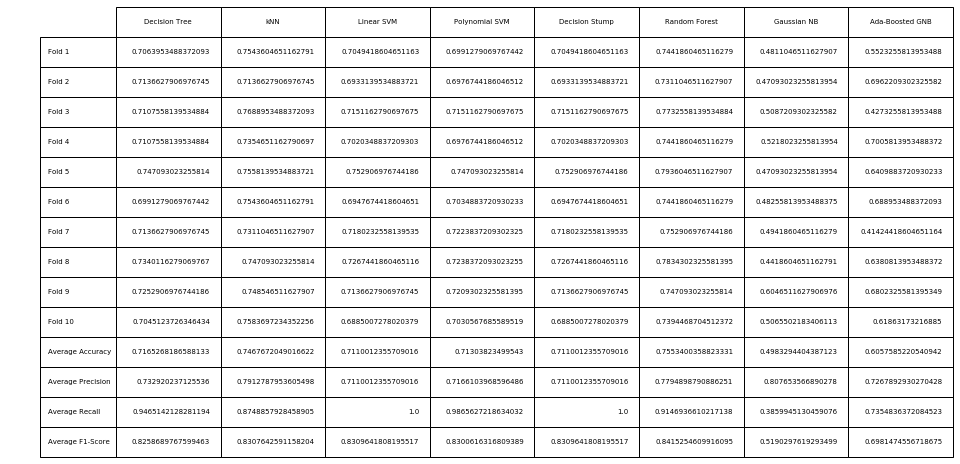

In [37]:
# Create a table of all the results
# Produce a table of the accuracies for each model over the 10 folds
# https://matplotlib.org/examples/pylab_examples/table_demo.html
table_vals = []
for dt, knn, svml, svmp, ds, rf, gnb, ab_gnb in zip(scores_dt, scores_knn, scores_svml, scores_svmp, scores_ds, scores_rf, scores_gnb, scores_ab_gnb):
    table_vals.append([dt, knn, svml, svmp, ds, rf, gnb, ab_gnb])
table_vals.append([avg_score_dt, avg_score_knn, avg_score_svml, avg_score_svmp, avg_score_ds, avg_score_rf, avg_score_gnb, avg_score_ab_gnb])
table_vals.append([avg_precision_dt, avg_precision_knn, avg_precision_svml, avg_precision_svmp, avg_precision_ds, avg_precision_rf, avg_precision_gnb, avg_precision_ab_gnb])
table_vals.append([avg_recall_dt, avg_recall_knn, avg_recall_svml, avg_recall_svmp, avg_recall_ds, avg_recall_rf, avg_recall_gnb, avg_recall_ab_gnb])
table_vals.append([avg_f1_dt, avg_f1_knn, avg_f1_svml, avg_f1_svmp, avg_f1_ds, avg_f1_rf, avg_f1_gnb, avg_f1_ab_gnb])

row_text = ["Fold " + str(k) for k in range(1, 11)]
row_text.append("Average Accuracy")
row_text.append("Average Precision")
row_text.append("Average Recall")
row_text.append("Average F1-Score")

# Plotting only the table
# https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
figure, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=table_vals, 
                 rowLabels=row_text, 
                 colLabels=["Decision Tree", "kNN", "Linear SVM", "Polynomial SVM", "Decision Stump", "Random Forest", "Gaussian NB", "Ada-Boosted GNB"], 
                 loc="center")
table.scale(2.5, 2.5)
plt.show()

Discuss the ROC Curves and the results here to form a hypothesis of the statistical testing here...

In [38]:
# Perform pared t-tests between each model to determine if there are any with a
# statistically significant difference from another.
from scipy import stats
# Get the p-values. We use alpha=0.05 to determine if our null-hypothesis holds
p_vals = []
col_labels = []
# DT-kNN
col_labels.append("DT-kNN")
p_vals.append(stats.ttest_rel(scores_dt, scores_knn)[1])
# DT-SVML
col_labels.append("DT-SVML")
p_vals.append(stats.ttest_rel(scores_dt, scores_svml)[1])
# DT-SVMP
col_labels.append("DT-SVMP")
p_vals.append(stats.ttest_rel(scores_dt, scores_svmp)[1])
# DT-DS
col_labels.append("DT-DS")
p_vals.append(stats.ttest_rel(scores_dt, scores_ds)[1])
# DT-RF
col_labels.append("DT-RF")
p_vals.append(stats.ttest_rel(scores_dt, scores_rf)[1])
# DT-GNB
col_labels.append("DT-GNB")
p_vals.append(stats.ttest_rel(scores_dt, scores_gnb)[1])
# DT-ABGNB
col_labels.append("DT-ABGNB")
p_vals.append(stats.ttest_rel(scores_dt, scores_ab_gnb)[1])
# kNN-SVML
col_labels.append("kNN-SVML")
p_vals.append(stats.ttest_rel(scores_knn, scores_svml)[1])
# kNN-SVMP
col_labels.append("kNN-SVMP")
p_vals.append(stats.ttest_rel(scores_knn, scores_svmp)[1])
# kNN-DS
col_labels.append("kNN-DS")
p_vals.append(stats.ttest_rel(scores_knn, scores_ds)[1])
# kNN-RF
col_labels.append("kNN-RF")
p_vals.append(stats.ttest_rel(scores_knn, scores_rf)[1])
# kNN-GNB
col_labels.append("kNN-GNB")
p_vals.append(stats.ttest_rel(scores_knn, scores_gnb)[1])
# kNN-ABGNB
col_labels.append("kNN-ABGNB")
p_vals.append(stats.ttest_rel(scores_knn, scores_ab_gnb)[1])
# SVML-SVMP
col_labels.append("SVML-SVMP")
p_vals.append(stats.ttest_rel(scores_svml, scores_svmp)[1])
# SVML-DS
col_labels.append("SVML-DS")
p_vals.append(stats.ttest_rel(scores_svml, scores_ds)[1])
# SVML-RF
col_labels.append("SVML-RF")
p_vals.append(stats.ttest_rel(scores_svml, scores_rf)[1])
# SVML-GNB
col_labels.append("SVML-GNB")
p_vals.append(stats.ttest_rel(scores_svml, scores_gnb)[1])
# SVML-ABGNB
col_labels.append("SVML-ABGNB")
p_vals.append(stats.ttest_rel(scores_svml, scores_ab_gnb)[1])
# SVMP-DS
col_labels.append("SVMP-DS")
p_vals.append(stats.ttest_rel(scores_svmp, scores_ds)[1])
# SVMP-RF
col_labels.append("SVMP-RF")
p_vals.append(stats.ttest_rel(scores_svmp, scores_rf)[1])
# SVMP-GNB
col_labels.append("SVMP-GNB")
p_vals.append(stats.ttest_rel(scores_svmp, scores_gnb)[1])
# SVMP-ABGNB
col_labels.append("SVMP-ABGNB")
p_vals.append(stats.ttest_rel(scores_svmp, scores_ab_gnb)[1])
# DS-RF
col_labels.append("DS-RF")
p_vals.append(stats.ttest_rel(scores_ds, scores_rf)[1])
# DS-GNB
col_labels.append("DS-GNB")
p_vals.append(stats.ttest_rel(scores_ds, scores_gnb)[1])
# DS-ABGNB
col_labels.append("DS-ABGNB")
p_vals.append(stats.ttest_rel(scores_ds, scores_ab_gnb)[1])
# RF-GNB
col_labels.append("RF-GNB")
p_vals.append(stats.ttest_rel(scores_rf, scores_gnb)[1])
# RF-ABGNB
col_labels.append("RF-ABGNB")
p_vals.append(stats.ttest_rel(scores_rf, scores_ab_gnb)[1])
# GNB-ABGNB
col_labels.append("GNB-ABGNB")
p_vals.append(stats.ttest_rel(scores_gnb, scores_ab_gnb)[1])

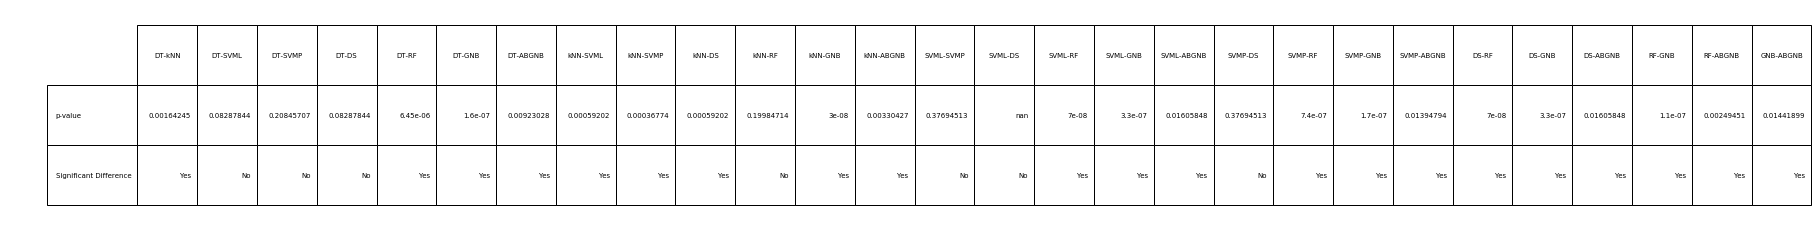

In [41]:
# NOTE: To view table clearly, just save it or open the image in a new tab
# Test for Statistical Significance
# Produce a table of the p-values to determine which contain a significant difference
sig_difs = []
for val in p_vals:
    if (val <= 0.05):
        sig_difs.append("Yes")
    else:
        sig_difs.append("No")

table_vals = [[round(val, 8) for val in p_vals], sig_difs]

row_text = ["p-value", "Significant Difference"]
# Plotting only the table
# https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
figure, ax = plt.subplots()

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=table_vals, 
                 rowLabels=row_text, 
                 colLabels=col_labels, 
                 loc="center")
table.scale(5, 5)
plt.show()

So we know, with 95% confidence, that there are the following model pairs have a statistically significance difference between each other:   
1) Decision Tree and kNN   
2) Decision Tree and Random Forest    
3) Decition Tree and Gaussian Naive Bayes     
4) Decision Tree and Ada Boosted Gaussian Naive Bayes     
5) kNN and Linear SVM     
6) kNN and Polynomial SVM     
7) kNN and Decision Stump    
8) kNN and Gaussian Naive Bayes    
9) kNN and Ada Boosted Gaussian Naive Bayes    
10) Linear SVM and Random Forest    
11) Linear SVM and Gaussian Naive Bayes     
12) Linear SVM and Ada Boosted Gaussian Naive Bayes
13) Polynomial SVM and Random Forest    
14) Polynomial SVM and Gaussian Naive Bayes    
15) Polynomial SVM and Ada Boosted Gaussian Naive Bayes   
16) Decision Stump and Random Forest    
17) Decision Stump and Gaussian Naive Bayes    
18) Decision Stump and Ada Boosted Gaussian Naive Bayes     
19) Random Forest and Gaussian Naive Bayes    
20) Random Forest and Ada Boosted Gaussian Naive Bayes   
21) Gaussian Naive Bayes and Ada Boosted Gaussian Naive Bayes

Finally we will choose two of the strongest classifiers, kNN and Random Forest, and try leaving one feature out during each run. We will see how the results change when we run the algorithms without each feature. This will exhibit the importance of the feature to the problem (what is most important in understanding when a Strategy Application is likely to be downloaded based on its rating likelihood).

In [73]:
feature_names = []
for col in df_full:
    feature_names.append(col)

In [80]:
# kNN
print("All Features: Accuracy = 0.7467672049016622 , Precision = 0.7912787953605498 , Recall = 0.8748857928458905 , F1-Score = 0.8307642591158204")
for i in range(len(feature_names)):
    X_test = X_us[:,[k for k in range(len(feature_names)) if k != i]]
    knn = KNeighborsClassifier(n_neighbors=7, metric="manhattan", weights="distance")
    scores_knn, avg_score_knn, avg_precision_knn, avg_recall_knn, avg_f1_knn = cross_val(knn, X_test, y_us)
    print("Leave out", feature_names[i], ": Accuracy =", avg_score_knn, ", Precision =", avg_precision_knn, ", Recall =", avg_recall_knn, ", F1-Score =", avg_f1_knn)

All Features: Accuracy = 0.7467672049016622 , Precision = 0.7912787953605498 , Recall = 0.8748857928458905 , F1-Score = 0.8307642591158204
Leave out Total Ratings : Accuracy = 0.7409490200060932 , Precision = 0.7894285929066599 , Recall = 0.8669096119131341 , F1-Score = 0.8261945088004289
Leave out Price : Accuracy = 0.7444373920991165 , Precision = 0.7900073806421612 , Recall = 0.8725165341418638 , F1-Score = 0.8290038983352659
Leave out Average IAP : Accuracy = 0.7088224840052808 , Precision = 0.7681027510820677 , Recall = 0.8457457297611203 , F1-Score = 0.8049038164327212
Leave out Languages : Accuracy = 0.7296118107037677 , Precision = 0.7846033011252316 , Recall = 0.8544974157247109 , F1-Score = 0.8178176262121168
Leave out Games Genre : Accuracy = 0.7440038844318065 , Precision = 0.7898458195194199 , Recall = 0.8721218584153603 , F1-Score = 0.8287763819433801
Leave out Total Genres : Accuracy = 0.7229280914660979 , Precision = 0.7758618125718025 , Recall = 0.8585269223563488 , F1

In [81]:
# Random Forest
print("With all Features: Accuracy = 0.7553400358823331 , Precision = 0.7794898790886251 , Recall = 0.9146936610217138 , F1-Score = 0.8415254609916095")
for i in range(len(feature_names)):
    X_test = X_us[:,[k for k in range(len(feature_names)) if k != i]]
    rf = RandomForestClassifier(n_estimators=200, max_depth=45, criterion="entropy", random_state=1)
    scores_rf, avg_score_rf, avg_precision_rf, avg_recall_rf, avg_f1_rf = cross_val(rf, X_test, y_us)
    print("Leave out", feature_names[i], ": Accuracy =", avg_score_rf, ", Precision =", avg_precision_rf, ", Recall =", avg_recall_rf, ", F1-Score =", avg_f1_rf)

With all Features: Accuracy = 0.7553400358823331 , Precision = 0.7794898790886251 , Recall = 0.9146936610217138 , F1-Score = 0.8415254609916095
Leave out Total Ratings : Accuracy = 0.7486522968078264 , Precision = 0.7824997544814558 , Recall = 0.895174639658934 , F1-Score = 0.8349012093674663
Leave out Price : Accuracy = 0.7477816847770895 , Precision = 0.7788156381588198 , Recall = 0.9011932925605066 , F1-Score = 0.8353984943277594
Leave out Average IAP : Accuracy = 0.7313557851799194 , Precision = 0.7696355060679172 , Recall = 0.8879136750586897 , F1-Score = 0.8243593128150837
Leave out Languages : Accuracy = 0.7442935242544261 , Precision = 0.7741626692058163 , Recall = 0.9040845589255329 , F1-Score = 0.8339369408412767
Leave out Games Genre : Accuracy = 0.7519970126265191 , Precision = 0.7777622910650359 , Recall = 0.9116701114798283 , F1-Score = 0.8392738775468007
Leave out Total Genres : Accuracy = 0.7408043058799634 , Precision = 0.7727966915193858 , Recall = 0.8997029986152121 

From the above we can conclude the following due to either increases or minimal change to the accuracy and precision.   
1) Age Rating (in general) is not a useful feature which could be removed    
2) Total Ratings has an effect, but not that much of one    
3) Size has a big impact on the likely success of a strategy game    
4) Average In App Purchases has a big impact on the likely success of a strategy game    
5) Having a subtitle helps a but with identifying the likely success of a strategy game    
6) The total number of genres helps identify the likely success of a strategy game    
7) The number of languages also has an impact on the likelihood to download    
8) The simplicity of the title has an impact on the likeligood to download    
9) All others have a minor impact on the task and could be ignored if needed

**6. Insight on algorithms' strengths and limitations**

***6.1 Insight - Decision Trees***    
A fairly standard approach that gavce standard results. Nothing great, but a decent approach with the features selected. It mainly focuses on the majority class to achieve the overall better results. This is why the max_depth is low. It keeps the splits simpler to make sure that the majority class is more often accurately predicted.   

***6.2 Insight - kNN***    
Gave very interesting results. The weighted kNN with manhattan distance gave the overall best results with a high k value of seven. Meanwhile, the best non-weighted kNN approach uses k as one with Euclidean Distance. This exhibits that 1NN can be useful depending on the task and dataset. It also exhibits the importance of testing k values, weight types, and distance metrics. Each dataset needs to have the parameters carefully selected. 

***6.3 Insight - SVM***    
The polynomial SVM and linear SVM have no statistically significant significance. The results were decent, but nothing spectacular. Using different tolerance levels may have changed some of the outcomes. Each test takes significantly longer with higher tolerances, so this would require more time to do. If we only cared about one class classification this would be a great approach.   

***6.4 Insight - Decision Stump***    
Not a good rule-based algorithm, but it is a simple one that is easy to integrate with the rest of the algorithms. The performance is poor, but it performs perfectly on the majority class (and a perfect failure on the minority class).

***6.5 Insight - Random Forests***    
Performed as one of, if not the best. This ensemble-based method exhibits clear improvement over the single decision tree and interestingly uses a different depth than a single decision tree for optimized results. A great approach that does not take too long to run.    

***6.6 Insight - Gaussian Naive Bayes***    
Gaussian Naive Bayes did not perform well, it was a weak learner. The features used are not good for this algorithm. One of the key reasons is due to the overall minor correlation between the data (implying no independence as assumed). Using different features such as including the full description, title, and subtitle would help this algorithm more than the selected features.   

***6.7 Insight - Ada Boosting Gaussian Naive Bayes***    
Since Gaussian Naive Bayes is a weak learner for this task, using a Boosting technique helped improve the results to be much better than without boosting. Furthermore, it performs worse overall, but does do a bit better at balancing the correct prediction of the minority class.   

**7. Final Discussion**   
Details on what was discovered through the above tasks, what was learned while working on the project, and providing complete insight into the overall story to be told.

Overall, this was an interesting project. This notebook perfiorms all techniques as learned in class and analyzes them carefully. The results should be improved in practice, but with more time this can easily be achieved.  
We have learned the pros and cons of different algorithms when presented data formatted a certain way, the effects of normalization techniques, how to tune algorithms, and how to derive concluding information to answer the question to our problem.   

The most important insight from this notebook is that we now better understand which features, shared by all applications on all storefronts, contribute to the likelihood of downloading the game. Which, could also be stated as which features help get higher ratings on strategy games on the Apple App Store.   

Given one full month to work on this project, I believe that serious results that would benefit developers can be achieved. That said, for this project, the lessons learned and experience help justify the obtained results.